# mu/sd 기반 편차 피처 => 반영
- 공정단계별 분해는 없음

In [ ]:
# -*- coding: utf-8 -*-
# ===============================================================
# Jupyter: SKU 개별 & 통합 (리드타임, 병목, 생산량) + mu/sd(σ) 반영
# - 입력: CSV 경로 (기본: "./Final Results Extended.csv")
# - 산출: ./outputs/ 아래에 모든 결과 저장
# - 주요 특징:
#   * SKU별 리드타임/생산량 타깃 생성
#   * 병목(행 단위 max _Queue) 통계
#   * RandomForest로 예측 + 중요도/퍼뮤테이션 중요도
#   * mu/sd 기반 편차 피처(분해 없이): SKUx_VA_z, 2σ/3σ flags
#   * What-if: 일반 Δ + σ 단위(예: SKU1_VA_z +1)
#   * 누수 방지 기본값: mu/sd 파생 피처는 "생산량 모델에만" 포함, 리드타임 모델에는 제외
# ===============================================================

# 0) 환경설정 & 로드
import os, re, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 160)

CSV_PATH = "./Final Results Extended.csv"   # 필요시 변경
OUT_DIR  = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH, low_memory=False)
print("=== Dataset shape ===", df.shape)
display(df.head(3))


# 1) 유틸
def to_numeric_df(d: pd.DataFrame) -> pd.DataFrame:
    return d.apply(pd.to_numeric, errors="coerce").fillna(0.0)

def savefig(path: str):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=140)
    plt.show()

def train_rf_model(
    X: pd.DataFrame, y: np.ndarray, test_size: float = 0.3, random_state: int = 42,
    n_estimators: int = 300
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    rf = RandomForestRegressor(
        n_estimators=n_estimators, max_depth=None, random_state=random_state, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    mae  = float(mean_absolute_error(y_test, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2   = float(r2_score(y_test, y_pred))

    fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

    pi = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    pi_s = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=False)

    metrics = {"MAE": round(mae, 3), "RMSE": round(rmse, 3), "R2": round(r2, 4)}
    return rf, (X_train, X_test, y_train, y_test), fi, pi_s, metrics


# 2) 컬럼 그룹핑
queue_cols = [c for c in df.columns if c.endswith("_Queue")]
util_cols  = [c for c in df.columns if c.endswith("_Util")]
cycle_cols = [c for c in df.columns if c.startswith("c_Cycle")]
cell_cols  = [c for c in df.columns if c.startswith("c_Cell")]

print("\n=== Column groups ===")
print(f"Queue cols  ({len(queue_cols)}): {queue_cols[:10]}{' ...' if len(queue_cols)>10 else ''}")
print(f"Util cols   ({len(util_cols)}):  {util_cols[:10]}{' ...' if len(util_cols)>10 else ''}")
print(f"Cycle cols  ({len(cycle_cols)}): {cycle_cols[:10]}")
print(f"Cell cols   ({len(cell_cols)}):  {cell_cols[:10]}{' ...' if len(cell_cols)>10 else ''}")


# 3) SKU 탐지 & 리드타임 컬럼 탐색
sku_ids = sorted({re.findall(r"SKU(\d+)_", c)[0] for c in df.columns if re.findall(r"SKU(\d+)_", c)})
print("\n=== Detected SKUs ===", sku_ids)

LT_PATTERNS = dict(
    VA=["_VA_Time_sec", "_VA_Time", "_VA"],
    WAIT=["_Wait_Time_sec", "_Wait_Time", "_Wait"],
    LIFT=["_Transport_Time_sec", "_Transport_Time", "_Transport", "_Lift"],
    TOTAL=["_Total_sec", "_LeadTime_sec", "_LeadTime"]
)

def find_first_existing(base: str, suffixes: List[str]) -> str:
    for s in suffixes:
        col = base + s
        if col in df.columns:
            return col
    return None

# SKU별 리드타임/생산량 타깃
sku_targets = {}
for sid in sku_ids:
    base = f"SKU{sid}"
    col_VA   = find_first_existing(base, LT_PATTERNS["VA"])
    col_WAIT = find_first_existing(base, LT_PATTERNS["WAIT"])
    col_LIFT = find_first_existing(base, LT_PATTERNS["LIFT"])
    col_TOT  = find_first_existing(base, LT_PATTERNS["TOTAL"])

    if col_TOT:
        lt_series = pd.to_numeric(df[col_TOT], errors="coerce").fillna(0.0)
        lt_name   = col_TOT
        lt_method = "TOTAL_col"
    else:
        VA   = pd.to_numeric(df[col_VA], errors="coerce").fillna(0.0) if col_VA else 0.0
        WAIT = pd.to_numeric(df[col_WAIT], errors="coerce").fillna(0.0) if col_WAIT else 0.0
        LIFT = pd.to_numeric(df[col_LIFT], errors="coerce").fillna(0.0) if col_LIFT else 0.0
        lt_series = pd.Series(VA, index=df.index) + pd.Series(WAIT, index=df.index) + pd.Series(LIFT, index=df.index)
        lt_name   = f"{base}_LeadTime_composed"
        lt_method = "VA+WAIT+LIFT"

    cell_cols_sku = [c for c in cell_cols if re.search(fr"__SKU{sid}\b", c)]
    if cell_cols_sku:
        prod_series = to_numeric_df(df[cell_cols_sku]).sum(axis=1)
        prod_name   = f"Total_SKU{sid}"
    else:
        prod_series = pd.Series(0.0, index=df.index)
        prod_name   = f"Total_SKU{sid}_zeros"

    sku_targets[sid] = dict(
        lead_time=lt_series, lead_time_name=lt_name, lead_time_method=lt_method,
        production=prod_series, production_name=prod_name,
        cell_cols=cell_cols_sku
    )

print("\n=== SKU targets overview (first 2 SKUs) ===")
for sid in sku_ids[:2]:
    print(f"SKU{sid} LT: {sku_targets[sid]['lead_time_name']} ({sku_targets[sid]['lead_time_method']}), "
          f"PROD: {sku_targets[sid]['production_name']} | #cell_cols={len(sku_targets[sid]['cell_cols'])}")


# 4) 통합 타깃 (생산량, 리드타임 가중평균)
if "c_TotalProducts" in df.columns:
    total_prod = pd.to_numeric(df["c_TotalProducts"], errors="coerce").fillna(0.0).astype("float32")
else:
    total_prod = to_numeric_df(df[[c for c in df.columns if c.startswith("c_Cell")]]).sum(axis=1).astype("float32")

# SKU별 리드타임 가중평균: 행렬을 만들지 않고 누적합으로 계산
N = len(df)
numerator = np.zeros(N, dtype=np.float32)  # Σ(lead_time_k * prod_k)
weights   = np.zeros(N, dtype=np.float32)  # Σ(prod_k)
sum_lt    = np.zeros(N, dtype=np.float32)  # fallback용 단순 평균 분자
k_count   = 0

for sid in sku_ids:
    lt = sku_targets[sid]["lead_time"].astype("float32").values
    pr = sku_targets[sid]["production"].astype("float32").values
    numerator += lt * pr
    weights   += pr
    sum_lt    += lt
    k_count   += 1

fallback_mean = (sum_lt / max(k_count, 1)).astype("float32")
with np.errstate(divide='ignore', invalid='ignore'):
    weighted_lt = np.where(weights > 0.0, numerator / weights, fallback_mean)

agg_lead_time = pd.Series(weighted_lt, index=df.index, name="Agg_LeadTime_weighted")


# 5) (신규) mu/sd 기반 편차 피처 — 분해 없이, SKU별 VA 대비 (μ합, σ합)
#    - 기본 제공(예시) 값: SKU1용
#    - 다른 SKU는 동일값 복제 사용 (필요시 dict에 SKU2~ 추가)
MUSD: Dict[str, Dict[str, Dict[str, float]]] = {
    "SKU1": {
        "mu": {"BL":900.0, "PR":5.0, "AS":25.0, "PA":5400.0, "QL":55.0},
        "sd": {"BL":30.0,  "PR":0.1, "AS":0.1,  "PA":0.0,    "QL":2.04},
    }
}
REPLICATE_MUSD_TO_OTHERS = True            # True면 SKU1 값을 다른 SKU에도 복제
INCLUDE_MUSD_IN_LT_MODEL = False           # 리드타임 모델에 mu/sd 파생피처 포함? (기본 False: 누수 최소화)
INCLUDE_MUSD_IN_PROD_MODEL = True          # 생산량 모델에는 포함 (기본 True)

def build_musd_features(df: pd.DataFrame, sku_ids: List[str]) -> List[str]:
    created_cols = []
    for sid in sku_ids:
        key = f"SKU{sid}"
        if key not in MUSD and REPLICATE_MUSD_TO_OTHERS and "SKU1" in MUSD:
            MUSD[key] = MUSD["SKU1"]  # 복제

        if key not in MUSD:
            continue

        mu = MUSD[key]["mu"]; sd = MUSD[key]["sd"]
        mu_sum = mu["BL"] + mu["PR"] + mu["AS"] + mu["PA"] + mu["QL"]
        S_var  = sd["BL"]**2 + sd["PR"]**2 + sd["AS"]**2 + sd["QL"]**2  # PA(sd=0)는 분산 제외
        S_std  = np.sqrt(S_var) if S_var > 0 else 1.0

        # VA 원시값 찾기
        base = f"SKU{sid}"
        va_col = find_first_existing(base, LT_PATTERNS["VA"])
        if va_col is None:
            # VA 없으면 0으로 채우되, 피처는 생성
            VA = pd.Series(0.0, index=df.index)
        else:
            VA = pd.to_numeric(df[va_col], errors="coerce").fillna(0.0)

        dev_col = f"{base}_VA_dev"          # (sec) 편차: VA - μ합
        z_col   = f"{base}_VA_z"            # (σ)    z-score: (VA - μ합)/σ
        f2_col  = f"{base}_VA_out_2sigma"   # flag: |z|>2
        f3_col  = f"{base}_VA_out_3sigma"   # flag: |z|>3

        df[dev_col] = VA - mu_sum
        df[z_col]   = (VA - mu_sum) / S_std
        df[f2_col]  = (df[z_col].abs() > 2).astype(int)
        df[f3_col]  = (df[z_col].abs() > 3).astype(int)

        created_cols += [dev_col, z_col, f2_col, f3_col]
    return created_cols

musd_cols = build_musd_features(df, sku_ids)
print("\n=== mu/sd-derived feature columns ===")
print(musd_cols[:12], "..." if len(musd_cols) > 12 else "")


# 6) 병목 탐색 (전체/통합)
def compute_bottleneck_stats(df_: pd.DataFrame, target_series: pd.Series) -> pd.DataFrame:
    qcols = [c for c in df_.columns if c.endswith("_Queue")]
    if not qcols:
        return pd.DataFrame(columns=["bottleneck_col","top1_count","top1_mean_queue","mean_target"])
    Q = to_numeric_df(df_[qcols])
    max_idx = Q.values.argmax(axis=1)
    max_names = [qcols[i] for i in max_idx]
    max_vals = Q.max(axis=1).values
    out = (pd.DataFrame({
        "bottleneck_col": max_names,
        "bottleneck_val": max_vals,
        "target": pd.to_numeric(target_series, errors="coerce").fillna(0.0).values
    }).groupby("bottleneck_col")
      .agg(top1_count=("bottleneck_col","count"),
           top1_mean_queue=("bottleneck_val","mean"),
           mean_target=("target","mean"))
      .sort_values("top1_count", ascending=False)
      .reset_index())
    return out

bneck_total_prod = compute_bottleneck_stats(df, total_prod)
bneck_total_prod.to_csv(os.path.join(OUT_DIR, "bottleneck_totalProduction.csv"), index=False)

bneck_agg_lt = compute_bottleneck_stats(df, agg_lead_time)
bneck_agg_lt.to_csv(os.path.join(OUT_DIR, "bottleneck_aggLeadTime.csv"), index=False)

print("\n=== Bottleneck (by total production) ===")
display(bneck_total_prod.head(20))
print("\n=== Bottleneck (by aggregate lead time) ===")
display(bneck_agg_lt.head(20))


# 7) 피처 구성 규칙 (누수 방지)
time_like_regex = re.compile(r"(?:_Time|_sec|_LeadTime|_Total)", re.IGNORECASE)

def build_features_for_leadtime(df_: pd.DataFrame, exclude_cols: List[str], also_exclude: List[str]=None) -> pd.DataFrame:
    cols = []
    for c in df_.columns:
        if c in exclude_cols or c == "Time_Now":
            continue
        if time_like_regex.search(c):       # 시간/리드타임 계열 제거
            continue
        if also_exclude and c in also_exclude:
            continue
        cols.append(c)
    return to_numeric_df(df_[cols]) if cols else pd.DataFrame(index=df_.index)

def build_features_for_production(df_: pd.DataFrame, exclude_cols: List[str]) -> pd.DataFrame:
    cols = []
    for c in df_.columns:
        if c in exclude_cols or c == "Time_Now":
            continue
        if c.startswith("c_Cell"):          # 생산량 직접합산 열 제거(누수 방지)
            continue
        cols.append(c)
    return to_numeric_df(df_[cols]) if cols else pd.DataFrame(index=df_.index)

# 리드타임 모델에 mu/sd 피처를 제외(기본). 포함하고 싶으면 플래그 True로.
musd_cols_for_lt_exclusion = musd_cols if not INCLUDE_MUSD_IN_LT_MODEL else []


# 8) SKU별 리드타임/생산량 모델
per_sku_results = {}

for sid in sku_ids:
    # 리드타임
    y_lt = sku_targets[sid]["lead_time"].values
    exclude_lt = set(sku_targets[sid]["cell_cols"])
    exclude_lt |= {c for c in df.columns if c.startswith(f"SKU{sid}_") and time_like_regex.search(c)}
    X_lt = build_features_for_leadtime(df, list(exclude_lt), also_exclude=musd_cols_for_lt_exclusion)
    if X_lt.shape[1] == 0:
        print(f"[WARN] SKU{sid}: LeadTime features empty. Skipped.")
        lt_pack = None
    else:
        rf_lt, splits_lt, fi_lt, pi_lt, m_lt = train_rf_model(X_lt, y_lt)
        fi_lt.to_csv(os.path.join(OUT_DIR, f"fi_leadtime_SKU{sid}.csv"))
        pi_lt.to_csv(os.path.join(OUT_DIR, f"pi_leadtime_SKU{sid}.csv"))
        plt.figure(figsize=(8,6)); fi_lt.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Feature Importance (LeadTime) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"fi_leadtime_SKU{sid}_top20.png"))
        plt.figure(figsize=(8,6)); pi_lt.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Permutation Importance (LeadTime) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"pi_leadtime_SKU{sid}_top20.png"))
        lt_pack = dict(model=rf_lt, features=X_lt.columns.tolist(), metrics=m_lt, splits=splits_lt)

    # 생산량
    y_pr = sku_targets[sid]["production"].values
    exclude_pr = set(sku_targets[sid]["cell_cols"])
    X_pr_base = build_features_for_production(df, list(exclude_pr))
    # 생산량 모델에는 mu/sd 파생 피처를 기본 포함
    if INCLUDE_MUSD_IN_PROD_MODEL:
        # musd_cols 중 해당 SKU의 것만 선별(이름에 SKU{sid}_ 포함)
        musd_cols_this = [c for c in musd_cols if c.startswith(f"SKU{sid}_")]
        X_pr = pd.concat([X_pr_base, to_numeric_df(df[musd_cols_this])], axis=1) if musd_cols_this else X_pr_base
    else:
        X_pr = X_pr_base

    if X_pr.shape[1] == 0:
        print(f"[WARN] SKU{sid}: Production features empty. Skipped.")
        pr_pack = None
    else:
        rf_pr, splits_pr, fi_pr, pi_pr, m_pr = train_rf_model(X_pr, y_pr)
        fi_pr.to_csv(os.path.join(OUT_DIR, f"fi_production_SKU{sid}.csv"))
        pi_pr.to_csv(os.path.join(OUT_DIR, f"pi_production_SKU{sid}.csv"))
        plt.figure(figsize=(8,6)); fi_pr.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Feature Importance (Production) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"fi_production_SKU{sid}_top20.png"))
        plt.figure(figsize=(8,6)); pi_pr.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Permutation Importance (Production) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"pi_production_SKU{sid}_top20.png"))
        pr_pack = dict(model=rf_pr, features=X_pr.columns.tolist(), metrics=m_pr, splits=splits_pr)

    per_sku_results[sid] = dict(lead_time=lt_pack, production=pr_pack)


# 9) 통합(aggregate) 모델
X_lt_agg = build_features_for_leadtime(df, exclude_cols=[], also_exclude=musd_cols_for_lt_exclusion)
y_lt_agg = agg_lead_time.values
if X_lt_agg.shape[1] > 0:
    rf_lt_agg, splits_lt_agg, fi_lt_agg, pi_lt_agg, m_lt_agg = train_rf_model(X_lt_agg, y_lt_agg)
    fi_lt_agg.to_csv(os.path.join(OUT_DIR, "fi_leadtime_AGG.csv"))
    pi_lt_agg.to_csv(os.path.join(OUT_DIR, "pi_leadtime_AGG.csv"))
    plt.figure(figsize=(8,6)); fi_lt_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Feature Importance (LeadTime) - AGG")
    savefig(os.path.join(OUT_DIR, "fi_leadtime_AGG_top20.png"))
    plt.figure(figsize=(8,6)); pi_lt_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Permutation Importance (LeadTime) - AGG")
    savefig(os.path.join(OUT_DIR, "pi_leadtime_AGG_top20.png"))
else:
    rf_lt_agg, m_lt_agg = None, {"MAE": None, "RMSE": None, "R2": None}

def build_features_for_production_agg(df_: pd.DataFrame) -> pd.DataFrame:
    # 통합 생산량 모델: c_Cell* 제외 + (선택) 모든 SKU의 mu/sd 피처 포함
    base = build_features_for_production(df_, exclude_cols=[])
    if INCLUDE_MUSD_IN_PROD_MODEL and musd_cols:
        return pd.concat([base, to_numeric_df(df_[musd_cols])], axis=1)
    return base

X_pr_agg = build_features_for_production_agg(df)
y_pr_agg = total_prod.values
if X_pr_agg.shape[1] > 0:
    rf_pr_agg, splits_pr_agg, fi_pr_agg, pi_pr_agg, m_pr_agg = train_rf_model(X_pr_agg, y_pr_agg)
    fi_pr_agg.to_csv(os.path.join(OUT_DIR, "fi_production_AGG.csv"))
    pi_pr_agg.to_csv(os.path.join(OUT_DIR, "pi_production_AGG.csv"))
    plt.figure(figsize=(8,6)); fi_pr_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Feature Importance (Production) - AGG")
    savefig(os.path.join(OUT_DIR, "fi_production_AGG_top20.png"))
    plt.figure(figsize=(8,6)); pi_pr_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Permutation Importance (Production) - AGG")
    savefig(os.path.join(OUT_DIR, "pi_production_AGG_top20.png"))
else:
    rf_pr_agg, m_pr_agg = None, {"MAE": None, "RMSE": None, "R2": None}


# 10) What-if (일반 Δ + σ 단위)
def simulate_delta(model: RandomForestRegressor, X_base: pd.DataFrame, deltas: Dict[str, float]) -> Tuple[float, float, float]:
    X_sim = X_base.copy()
    for k, v in deltas.items():
        if k in X_sim.columns:
            X_sim[k] = X_sim[k] + v
    base_mean = float(model.predict(X_base).mean())
    new_mean  = float(model.predict(X_sim).mean())
    return base_mean, new_mean, new_mean - base_mean

# 공용 시나리오 + (예시) σ 단위 시나리오
scenarios_common = {
    "QUtil_plus5": {"Quality_Util": +5.0},
    "BlankingQ_minus50": {"Blanking_Queue": -50.0},
    "PaintUtil_plus5_BlankingQ_minus50": {"Paint1_Util": +5.0, "Paint2_Util": +5.0, "Blanking_Queue": -50.0},
}
# SKU별 σ 시나리오 추가 (해당 SKU의 mu/sd 파생 피처가 존재해야 효과)
scenarios_sigma = {}
for sid in sku_ids:
    z_name = f"SKU{sid}_VA_z"
    if z_name in df.columns:
        scenarios_sigma[f"{z_name}_plus1sigma"] = {z_name: +1.0}
scenarios_all = {**scenarios_common, **scenarios_sigma}

whatif_all = {"AGG": {"lead_time": None, "production": None}, "SKU": {}}

# 통합 What-if
if rf_lt_agg is not None:
    Xb = splits_lt_agg[1]
    lt_map = {}
    for name, d in scenarios_all.items():
        # 리드타임 모델은 기본설정상 z 피처를 사용하지 않으므로, 존재해도 영향이 없을 수 있음
        base_m, new_m, d_m = simulate_delta(rf_lt_agg, Xb, d)
        lt_map[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
    whatif_all["AGG"]["lead_time"] = lt_map

if rf_pr_agg is not None:
    Xb = splits_pr_agg[1]
    pr_map = {}
    for name, d in scenarios_all.items():
        base_m, new_m, d_m = simulate_delta(rf_pr_agg, Xb, d)
        pr_map[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
    whatif_all["AGG"]["production"] = pr_map

# SKU별 What-if
for sid, packs in per_sku_results.items():
    whatif_all["SKU"][sid] = {}

    if packs["lead_time"] is not None:
        rf = packs["lead_time"]["model"]
        (_, X_test, *_)= packs["lead_time"]["splits"]
        feats = set(packs["lead_time"]["features"])
        lt_map = {}
        for name, d in scenarios_all.items():
            d_sub = {k:v for k,v in d.items() if k in feats}
            if not d_sub: 
                continue
            base_m, new_m, d_m = simulate_delta(rf, X_test[list(d_sub.keys())], d_sub)
            lt_map[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
        whatif_all["SKU"][sid]["lead_time"] = lt_map

    if packs["production"] is not None:
        rf = packs["production"]["model"]
        (_, X_test, *_)= packs["production"]["splits"]
        feats = set(packs["production"]["features"])
        pr_map = {}
        for name, d in scenarios_all.items():
            d_sub = {k:v for k,v in d.items() if k in feats}
            if not d_sub: 
                continue
            base_m, new_m, d_m = simulate_delta(rf, X_test[list(d_sub.keys())], d_sub)
            pr_map[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
        whatif_all["SKU"][sid]["production"] = pr_map

with open(os.path.join(OUT_DIR, "whatif_results.json"), "w", encoding="utf-8") as f:
    json.dump(whatif_all, f, ensure_ascii=False, indent=2)


# 11) 요약 저장
summary = {
    "cwd": os.getcwd(),
    "dataset_shape": tuple(df.shape),
    "detected_skus": sku_ids,
    "musd": {
        "provided": list(MUSD.keys()),
        "replicate_to_others": REPLICATE_MUSD_TO_OTHERS,
        "include_in_lt_model": INCLUDE_MUSD_IN_LT_MODEL,
        "include_in_prod_model": INCLUDE_MUSD_IN_PROD_MODEL,
        "created_cols_count": len(musd_cols)
    },
    "outputs": {
        "bneck_totalProduction_csv": os.path.join(OUT_DIR, "bottleneck_totalProduction.csv"),
        "bneck_aggLeadTime_csv": os.path.join(OUT_DIR, "bottleneck_aggLeadTime.csv"),
        "per_sku_fi_pi_png_csv": "fi_*.csv / pi_*.csv / *_top20.png in outputs/",
        "agg_fi_pi_png_csv": "fi_*AGG*.csv / pi_*AGG*.csv / *_AGG_top20.png in outputs/",
        "whatif_json": os.path.join(OUT_DIR, "whatif_results.json"),
    },
    "notes": [
        "리드타임 모델은 기본적으로 mu/sd 파생 피처를 제외(INCLUDE_MUSD_IN_LT_MODEL=False)하여 누수 최소화.",
        "생산량 모델에는 mu/sd 파생 피처를 포함하여(기본 True) 설계 대비 편차의 효과를 반영.",
        "σ 시나리오 예: 'SKU1_VA_z': +1.0 → 해당 SKU의 VA가 평균 대비 +1σ 길어진 상황을 가정.",
    ]
}
with open(os.path.join(OUT_DIR, "SUMMARY.json"), "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\n=== SUMMARY ===")
print(json.dumps(summary, ensure_ascii=False, indent=2))

# 표준편차 등의 설정을 반영안한 버전

=== Dataset shape === (132676, 78)


,Time_Now,Blanking_Util,Blanking_SKU1_Queue,Blanking_SKU2_Queue,Blanking_SKU3_Queue,Blanking_SKU4_Queue,Press1_Util,Press2_Util,Press3_Util,Press4_Util,Press1_Queue,Press2_Queue,Press3_Queue,Press4_Queue,Cell1_Util,Cell2_Util,Cell3_Util,Cell4_Util,Cell1_Queue,Cell2_Queue,Cell3_Queue,Cell4_Queue,Warehouse1_Queue,Warehouse_2_Queue,Warehouse_3_Queue,Warehouse_4_Queue,c_Cycle1,c_Cycle2,c_Cycle3,c_Cycle4,c_Cell1_SKU1,c_Cell1__SKU2,c_Cell1__SKU3,c_Cell1__SKU4,c_Cell2__SKU1,c_Cell2__SKU2,c_Cell2__SKU3,c_Cell2__SKU4,c_Cell3__SKU1,c_Cell3__SKU2,c_Cell3__SKU3,c_Cell3__SKU4,c_Cell4__SKU1,c_Cell4__SKU2,c_Cell4__SKU3,c_Cell4__SKU4,Paint1_Util,Paint2_Util,Quality_Util,Paint1_Queue,Paint2_Queue,Quality_Queue,Forklift_Util,Forklift_Blanking_Queue,Forklift_Press_Queue,Forklift_Assembly_Queue,c_TotalProducts,SKU1_VA_Time,SKU1_NVA_Time,SKU1_Transport_Time,SKU1_Wait_Time,SKU1_Other_Time,SKU2_VA_Time,SKU2_NVA_Time,SKU2_Transport_Time,SKU2_Wait_Time,SKU2_Other_Time,SKU3_VA_Time,SKU3_NVA_Time,SKU3_Transport_Time,SKU3_Wait_Time,SKU3_Other_Time,SKU4_VA_Time,SKU4_NVA_Time,SKU4_Transport_Time,SKU4_Wait_Time,SKU4_Other_Time,Blanking_Queue
0,24,0.846367,0.045715,0.056373,0.055737,0.035849,0.410297,0.434561,0.481388,0.399992,56.540291,65.273786,52.970766,47.964826,0.848870,0.673814,0.705012,0.819405,0.0,0.0,0.0,0.0,98.155568,19.580277,77.580864,75.124986,22833.0,15515.0,16202.0,36728.0,13967.0,10867.0,0.0,4382.0,0.0,2851.0,0.0,4334.0,0.0,903.0,4707.0,0.0,0.0,0.0,11743.0,4934.0,0.472565,0.504126,0.432738,0.0,0.0,47.361617,0.606002,157.256741,142.123969,137.454854,54377.0,1.525651,0.0,0.536810,0.587305,0.0,1.522853,0.0,0.532394,0.441645,0.0,1.525071,0.0,0.537617,0.453650,0.0,1.523338,0.0,0.536243,0.473453,0.0,58.361452
1,24,0.851097,0.051937,0.052934,0.038512,0.042248,0.455471,0.454445,0.387975,0.442986,74.772823,52.530064,49.303143,59.119986,0.876750,0.660415,0.629526,0.803448,0.0,0.0,0.0,0.0,162.632374,18.164794,64.827578,69.374905,23688.0,16021.0,13241.0,37249.0,15071.0,11180.0,0.0,3615.0,0.0,2932.0,0.0,4125.0,0.0,1346.0,3852.0,0.0,0.0,0.0,9556.0,7484.0,0.482683,0.501912,0.436583,0.0,0.0,48.266912,0.599976,166.488725,142.113668,140.757582,54857.0,1.525665,0.0,0.534195,0.684177,0.0,1.522836,0.0,0.535767,0.401993,0.0,1.524986,0.0,0.536764,0.473677,0.0,1.523344,0.0,0.534992,0.464380,0.0,62.830599
2,24,0.846115,0.052210,0.047499,0.043181,0.040979,0.496717,0.450816,0.417308,0.352829,67.283036,72.901066,39.198518,33.994084,0.895845,0.660288,0.654895,0.766823,0.0,0.0,0.0,0.0,335.401556,20.369416,46.120108,71.720194,26456.0,15903.0,14142.0,35109.0,16603.0,11042.0,0.0,2260.0,0.0,2904.0,0.0,4149.0,0.0,1198.0,4139.0,0.0,0.0,0.0,10282.0,5575.0,0.476897,0.492906,0.429997,0.0,0.0,48.906418,0.576669,159.188501,148.427694,142.653371,54052.0,1.525644,0.0,0.535403,0.898331,0.0,1.522821,0.0,0.535631,0.427815,0.0,1.525064,0.0,0.535925,0.424090,0.0,1.523403,0.0,0.535077,0.475330,0.0,59.365867



=== Column groups ===
Queue cols  (23): ['Blanking_SKU1_Queue', 'Blanking_SKU2_Queue', 'Blanking_SKU3_Queue', 'Blanking_SKU4_Queue', 'Press1_Queue', 'Press2_Queue', 'Press3_Queue', 'Press4_Queue', 'Cell1_Queue', 'Cell2_Queue'] ...
Util cols   (13):  ['Blanking_Util', 'Press1_Util', 'Press2_Util', 'Press3_Util', 'Press4_Util', 'Cell1_Util', 'Cell2_Util', 'Cell3_Util', 'Cell4_Util', 'Paint1_Util'] ...
Cycle cols  (4): ['c_Cycle1', 'c_Cycle2', 'c_Cycle3', 'c_Cycle4']
Cell cols   (16):  ['c_Cell1_SKU1', 'c_Cell1__SKU2', 'c_Cell1__SKU3', 'c_Cell1__SKU4', 'c_Cell2__SKU1', 'c_Cell2__SKU2', 'c_Cell2__SKU3', 'c_Cell2__SKU4', 'c_Cell3__SKU1', 'c_Cell3__SKU2'] ...


,count,mean,std,min,25%,50%,75%,max
Blanking_Util,132676.0,0.852578,0.007213,0.827948,0.847558,0.852574,0.857599,0.876014
Press1_Util,132676.0,0.435444,0.048235,0.000000,0.402151,0.434539,0.467572,0.662241
Press2_Util,132676.0,0.436133,0.048422,0.000000,0.402882,0.435088,0.468230,0.654867
Press3_Util,132676.0,0.436716,0.048505,0.000000,0.403265,0.435517,0.468976,0.688360
Press4_Util,132676.0,0.436742,0.048440,0.000000,0.403357,0.435749,0.468948,0.683588
Cell1_Util,132676.0,0.866873,0.029286,0.000000,0.846982,0.867178,0.887178,0.959801
Cell2_Util,132676.0,0.700289,0.033549,0.000000,0.677553,0.700018,0.723108,0.834584
Cell3_Util,132676.0,0.663762,0.047393,0.000000,0.631160,0.662696,0.695359,0.896197
Cell4_Util,132676.0,0.813614,0.032118,0.000000,0.792229,0.814063,0.835693,0.938891
Paint1_Util,132676.0,0.483067,0.009942,0.000000,0.476237,0.483065,0.489914,0.517823


,count,mean,std,min,25%,50%,75%,max
Blanking_SKU1_Queue,132676.0,0.047019,0.006612,0.018525,0.042466,0.046885,0.051436,0.083648
Blanking_SKU2_Queue,132676.0,0.047035,0.006620,0.021391,0.042473,0.046882,0.051423,0.079058
Blanking_SKU3_Queue,132676.0,0.047063,0.006619,0.020240,0.042532,0.046899,0.051448,0.078178
Blanking_SKU4_Queue,132676.0,0.047023,0.006590,0.000000,0.042456,0.046879,0.051409,0.081219
Press1_Queue,132676.0,72.306267,16.525633,0.000000,60.625440,70.359215,81.744328,297.820526
Press2_Queue,132676.0,62.978046,14.125039,0.000000,53.011079,61.187592,70.920870,181.116501
Press3_Queue,132676.0,54.253860,12.992290,0.000000,45.073235,52.402491,61.410910,202.271210
Press4_Queue,132676.0,52.272118,12.696368,0.000000,43.308479,50.493633,59.203210,290.661926
Cell1_Queue,132676.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Cell2_Queue,132676.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



=== Detected SKUs === ['1', '2', '3', '4']

=== SKU targets overview (first 2 SKUs) ===
SKU1 LT: SKU1_LeadTime_composed (VA+WAIT+LIFT), PROD: Total_SKU1 | #cell_cols=3
SKU2 LT: SKU2_LeadTime_composed (VA+WAIT+LIFT), PROD: Total_SKU2 | #cell_cols=4

=== Bottleneck (by total production) ===


,bottleneck_col,top1_count,top1_mean_queue,mean_target
0,Warehouse1_Queue,77631,238.494370,54858.582061
1,Forklift_Blanking_Queue,53681,153.103226,54578.960060
2,Warehouse_3_Queue,1307,190.093475,55135.087223
3,Warehouse_4_Queue,36,171.744476,56690.416667
4,Forklift_Press_Queue,9,139.574982,54510.333333
5,Press4_Queue,6,178.058975,55440.833333
6,Press2_Queue,5,167.838791,55408.400000
7,Blanking_SKU3_Queue,1,0.051400,0.000000



=== Bottleneck (by aggregate lead time) ===


,bottleneck_col,top1_count,top1_mean_queue,mean_target
0,Warehouse1_Queue,77631,238.494370,2.513333
1,Forklift_Blanking_Queue,53681,153.103226,2.505023
2,Warehouse_3_Queue,1307,190.093475,2.577764
3,Warehouse_4_Queue,36,171.744476,2.568670
4,Forklift_Press_Queue,9,139.574982,2.501076
5,Press4_Queue,6,178.058975,2.546885
6,Press2_Queue,5,167.838791,2.540109
7,Blanking_SKU3_Queue,1,0.051400,0.000000


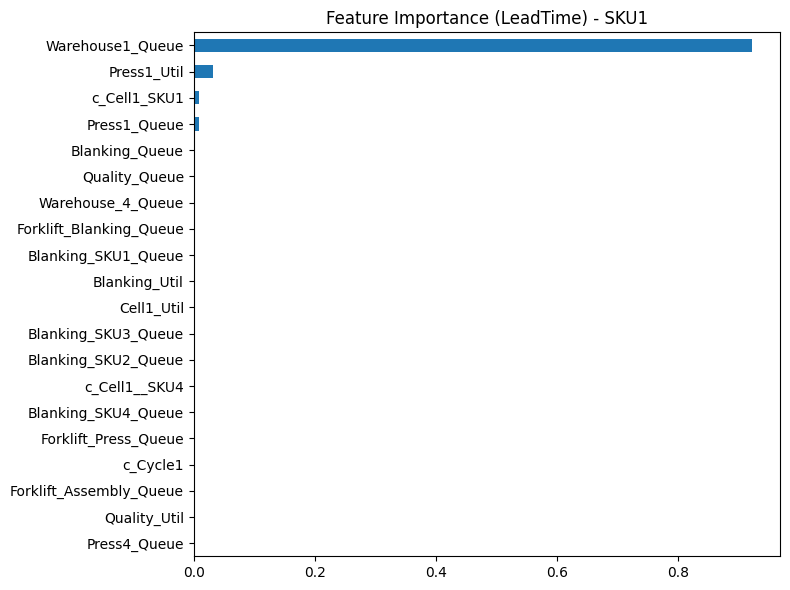

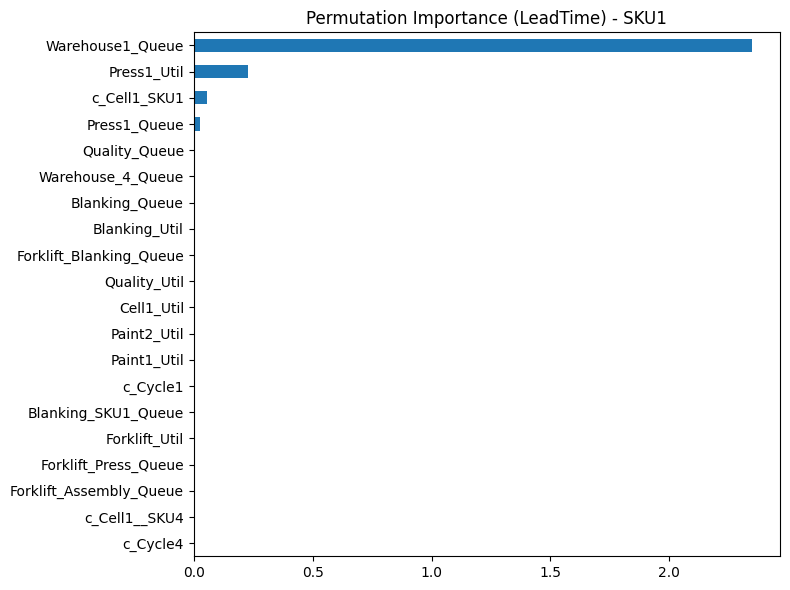

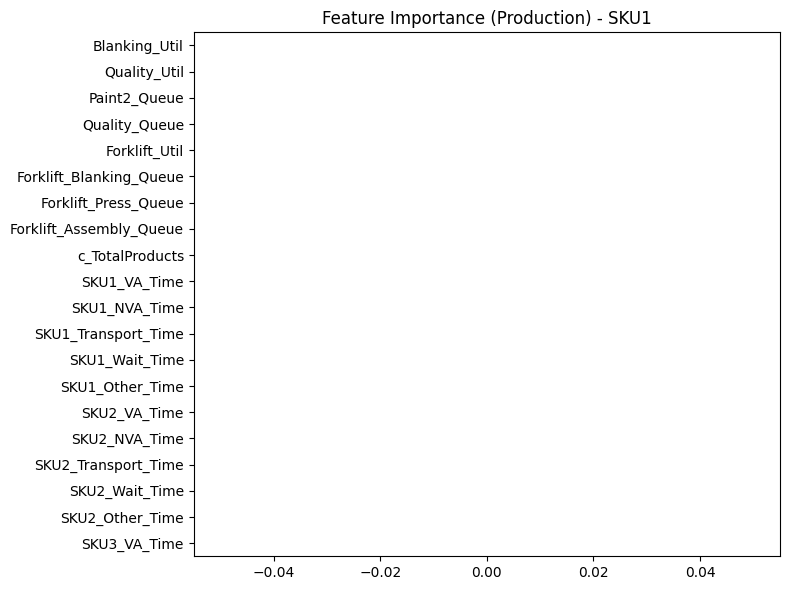

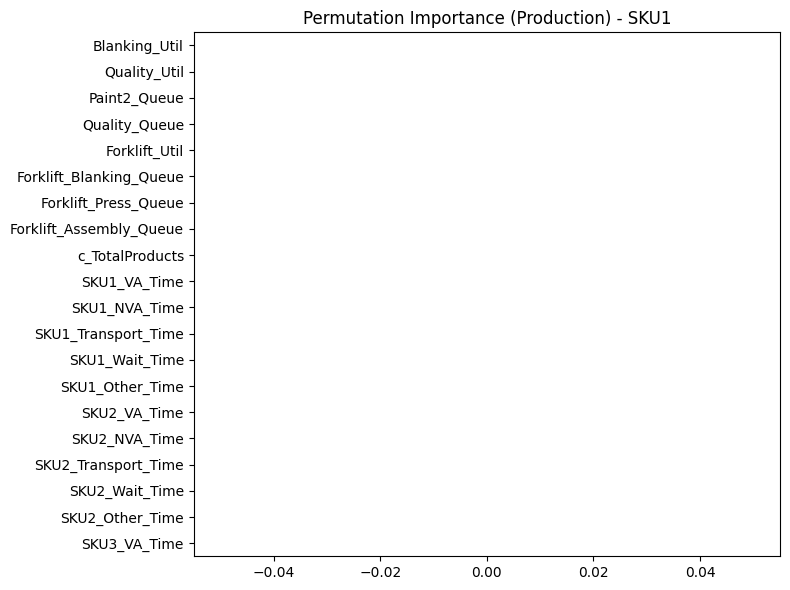

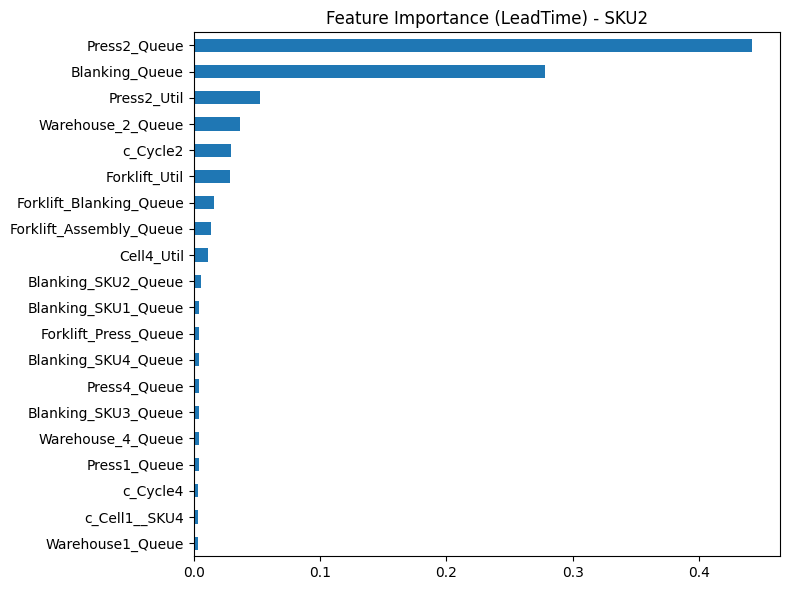

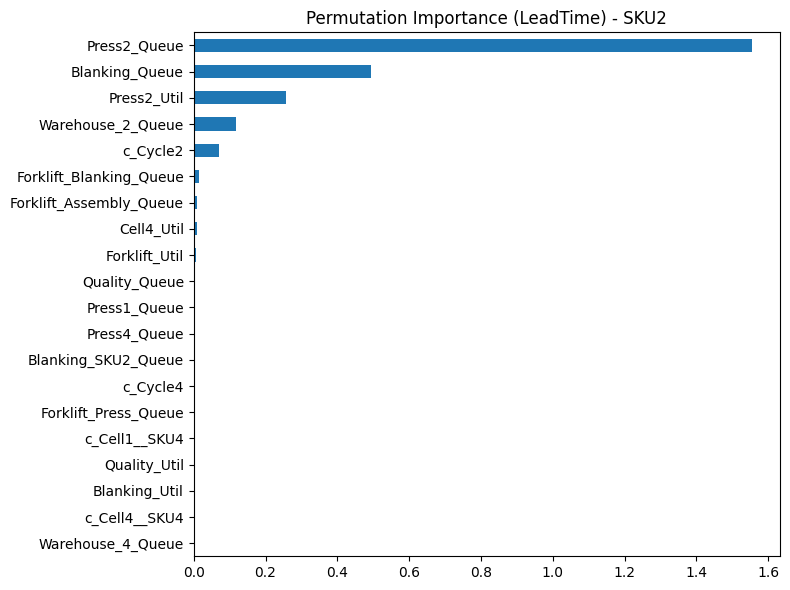

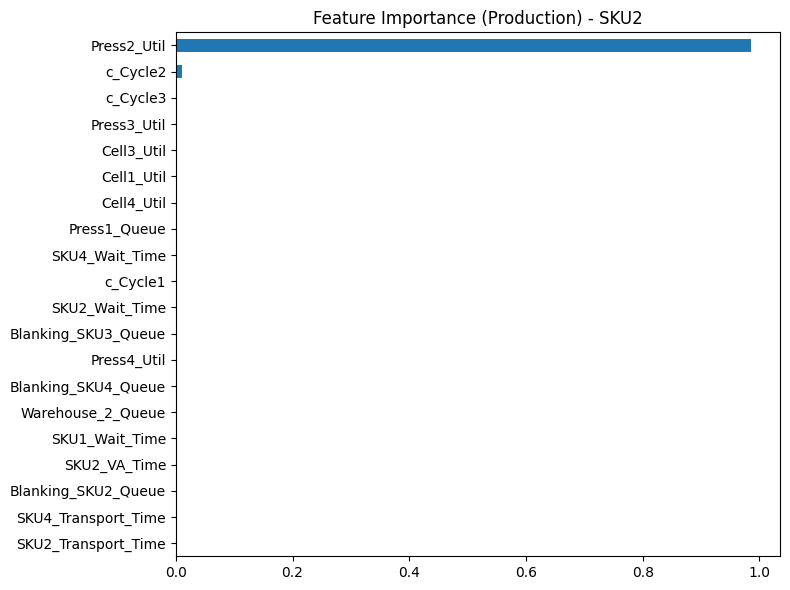

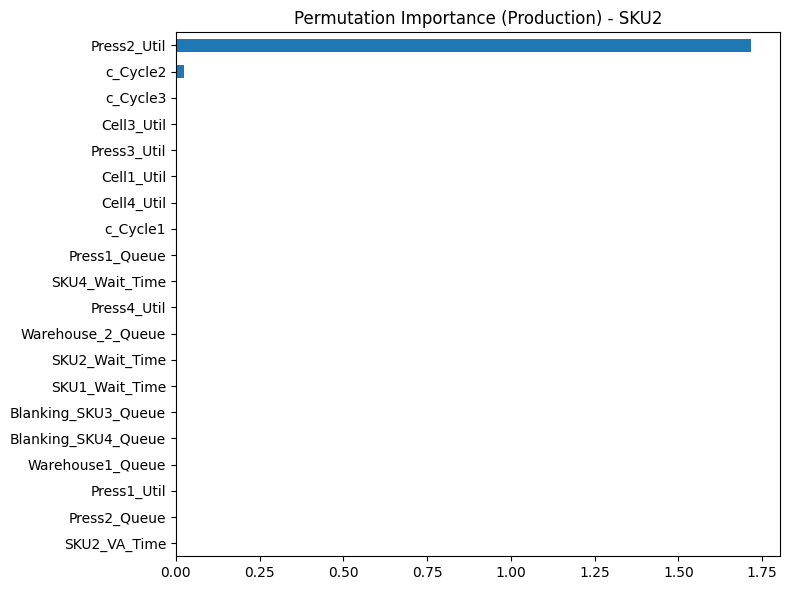

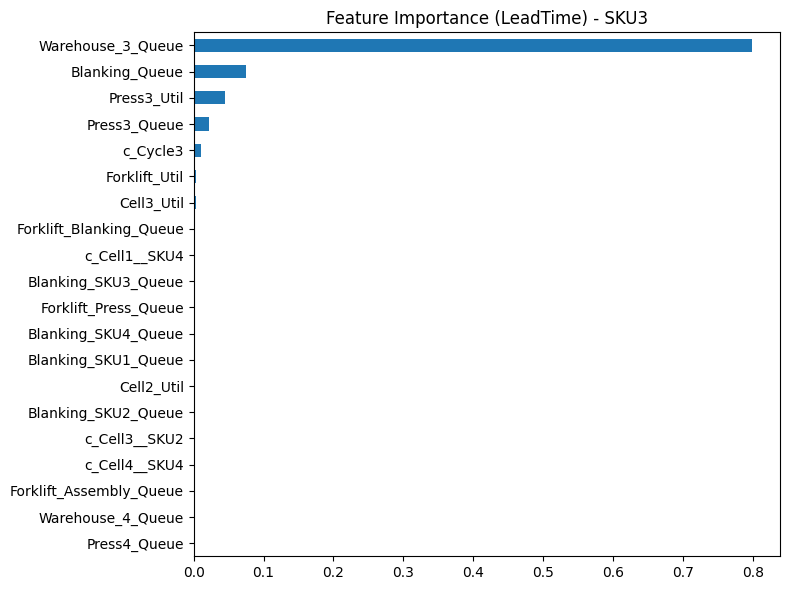

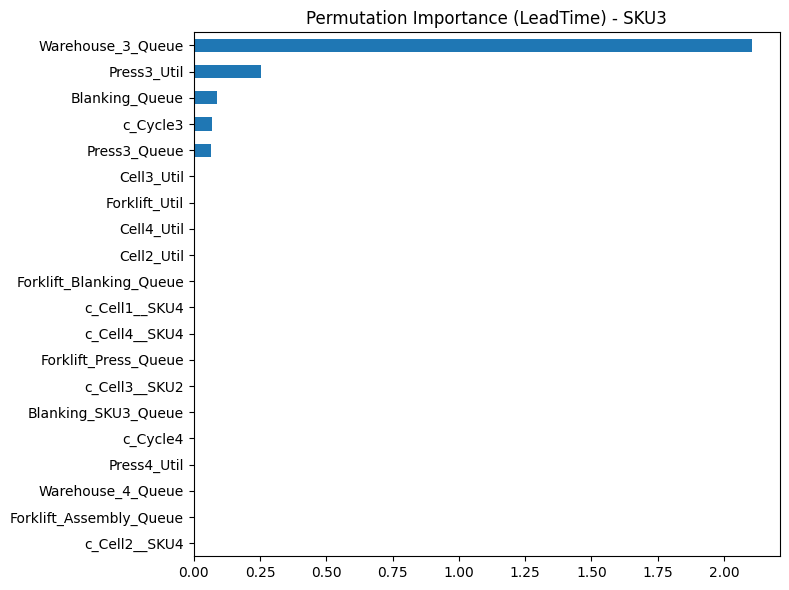

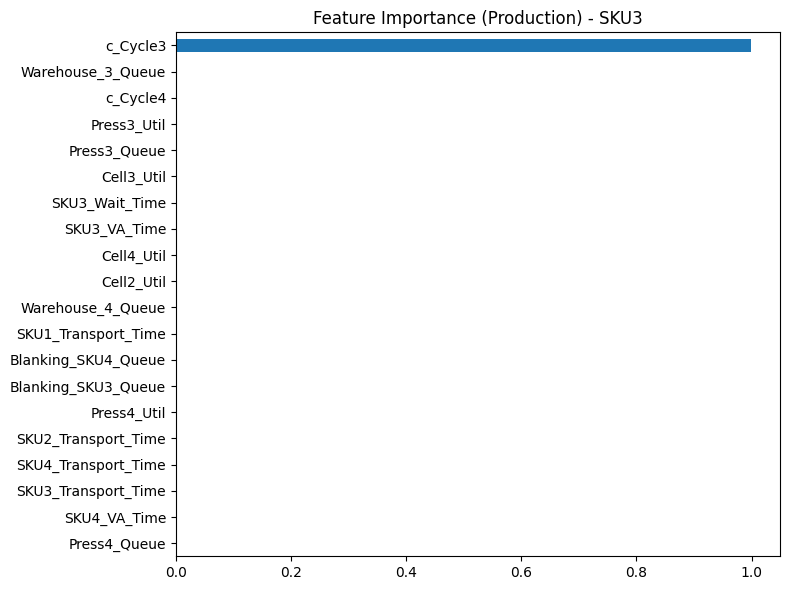

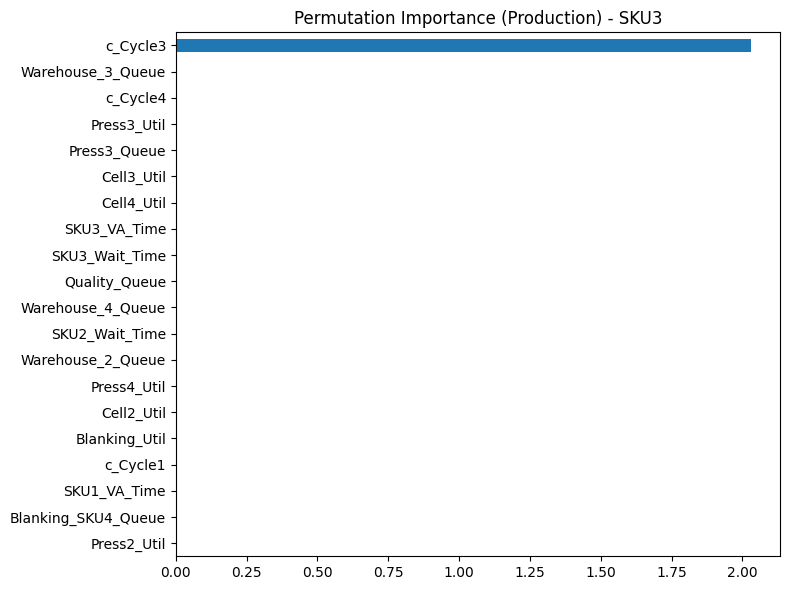

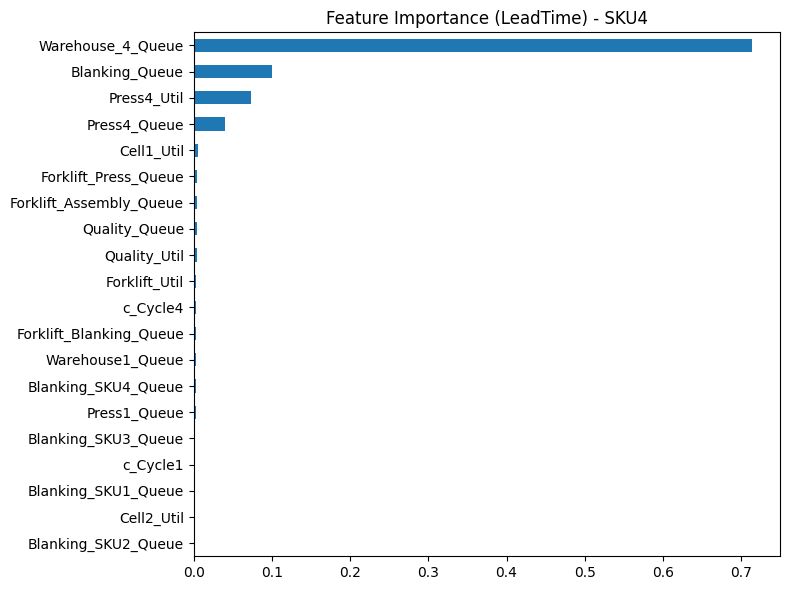

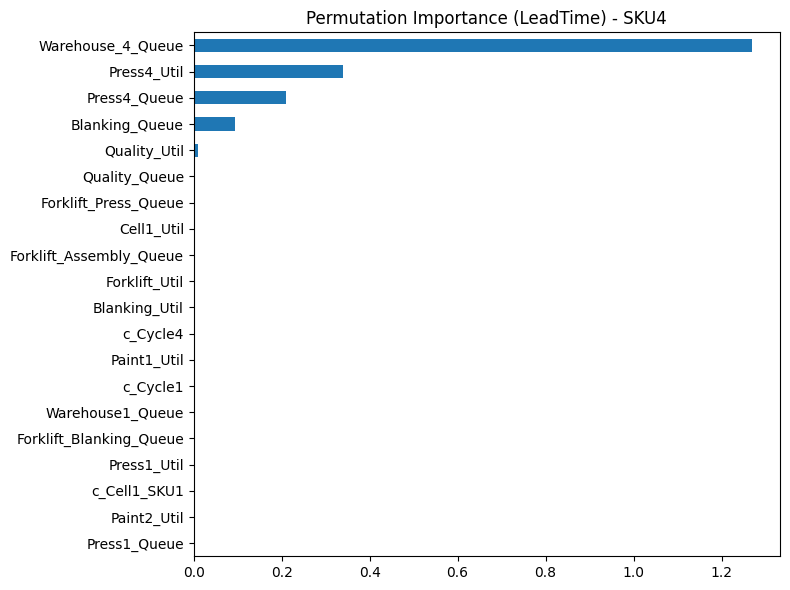

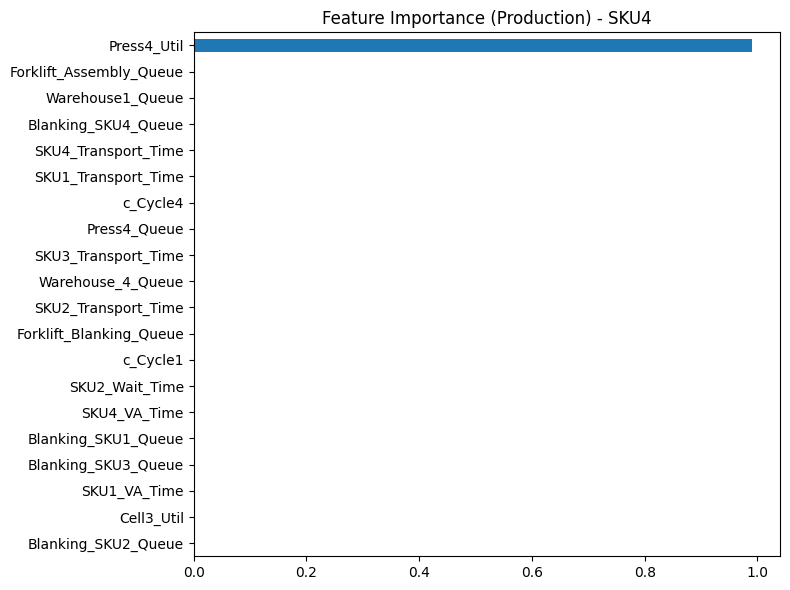

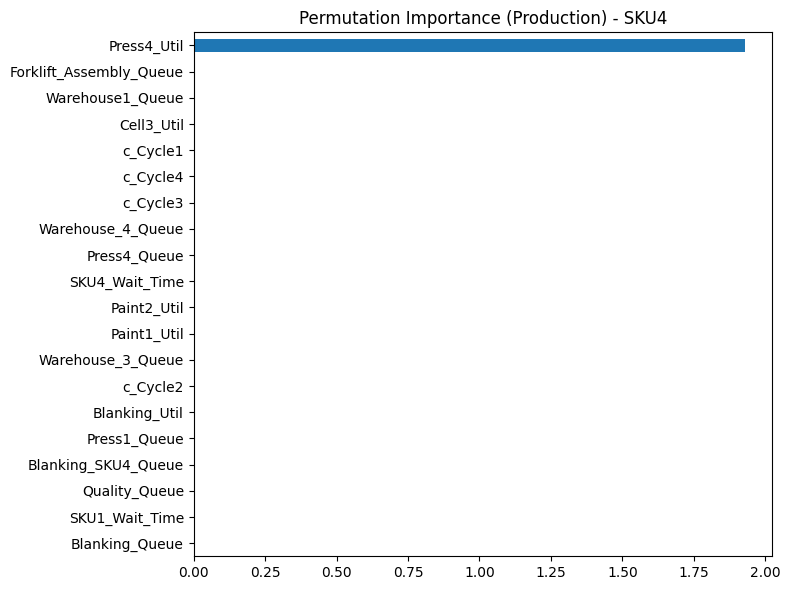

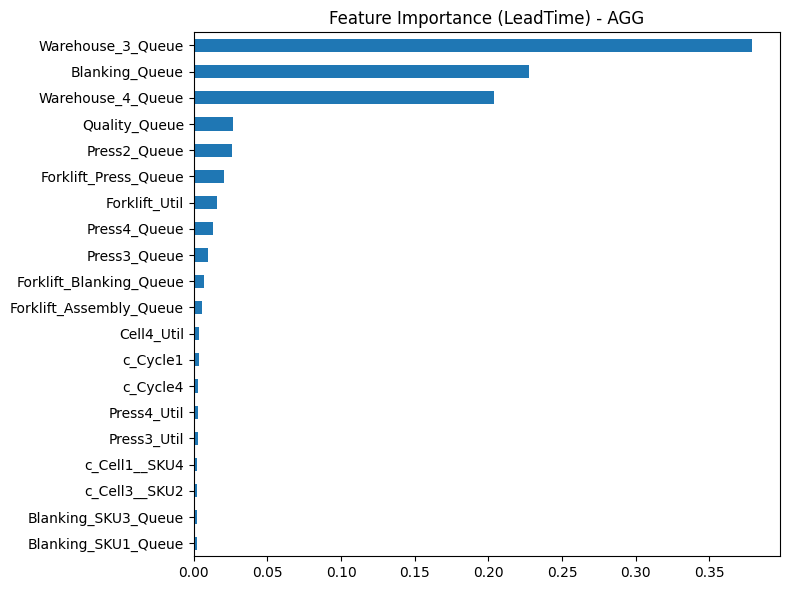

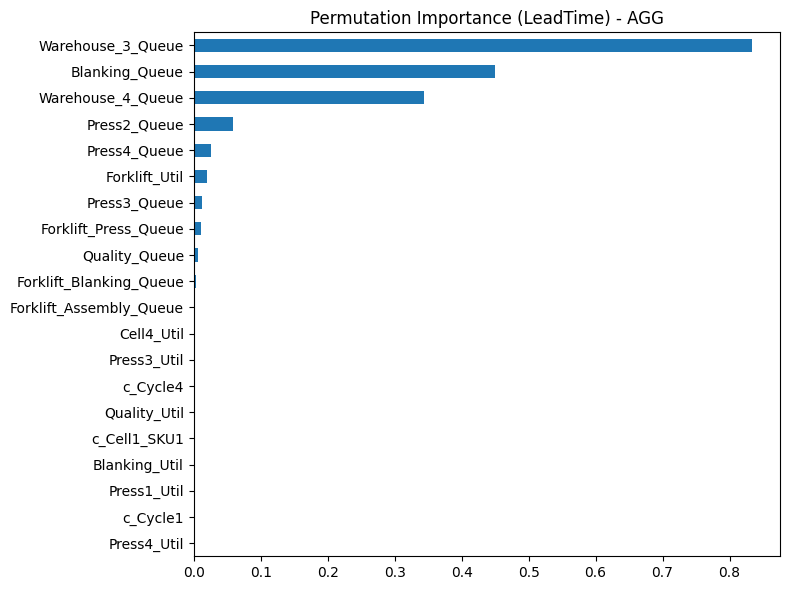

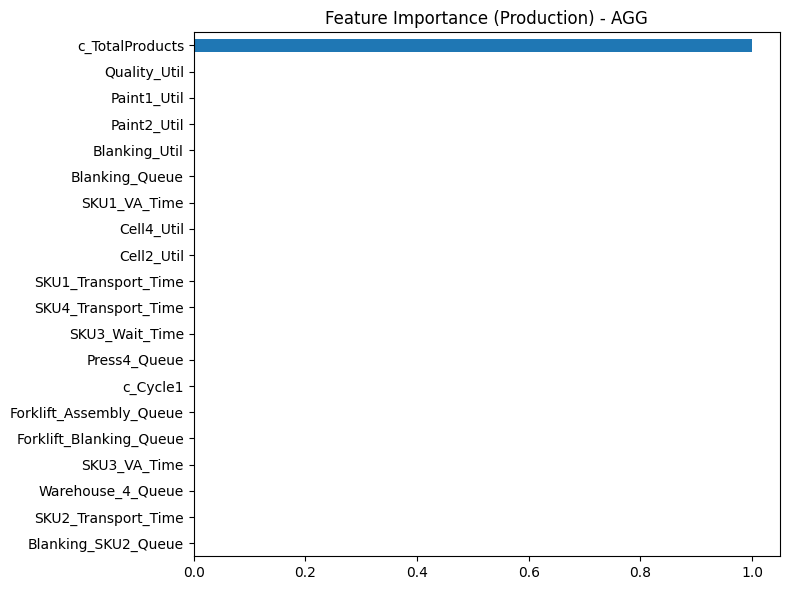

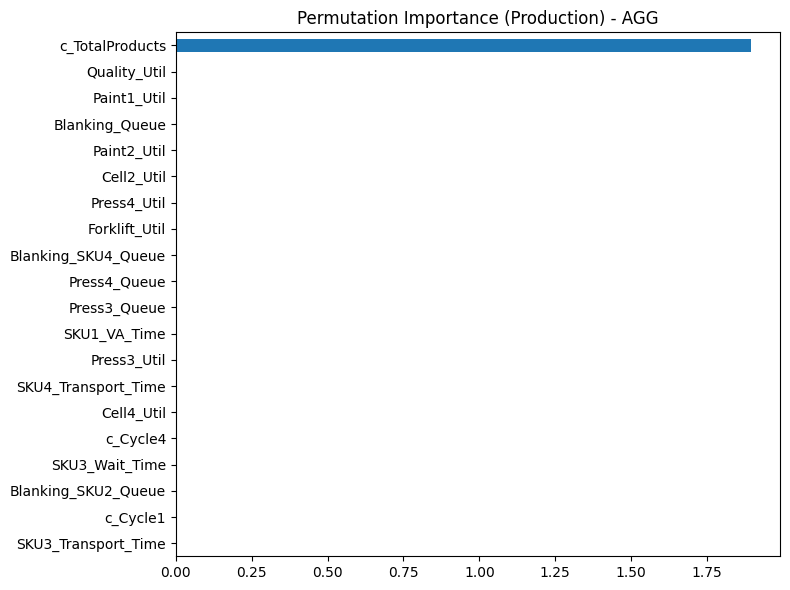


=== SUMMARY ===
{
  "cwd": "D:\\Project\\Python_Source\\Test01\\0819",
  "dataset_shape": [
    132676,
    78
  ],
  "detected_skus": [
    "1",
    "2",
    "3",
    "4"
  ],
  "outputs": {
    "bneck_totalProduction_csv": "./outputs\\bottleneck_totalProduction.csv",
    "bneck_aggLeadTime_csv": "./outputs\\bottleneck_aggLeadTime.csv",
    "per_sku_fi_pi_png_csv": "fi_*.csv / pi_*.csv / *_top20.png in outputs/",
    "agg_fi_pi_png_csv": "fi_*AGG*.csv / pi_*AGG*.csv / *_AGG_top20.png in outputs/",
    "whatif_json": "./outputs\\whatif_results.json"
  },
  "notes": [
    "리드타임 모델: *_Time / *_sec / *_LeadTime / *_Total 계열은 입력 피처에서 제외해 누수 방지.",
    "생산량 모델: c_Cell* 계열은 입력 피처에서 제외해 누수 방지.",
    "통합 리드타임 = SKU별 리드타임의 생산량 가중 평균(가중치 합 0이면 단순 평균)."
  ]
}


In [2]:
# -*- coding: utf-8 -*-
# ===============================================================
# Jupyter: SKU 개별 & 통합 분석 (리드타임, 병목, 생산량)
# - 입력: CSV 경로 (기본: "./Final Results Extended.csv")
# - 산출: ./outputs/ 아래에 모든 결과 저장
# ===============================================================

# 0) 환경설정 & 로드
import os, json, re, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, List, Tuple

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 160)

CSV_PATH = "./Final Results Extended.csv"   # 필요시 변경
OUT_DIR  = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(CSV_PATH, low_memory=False)

print("=== Dataset shape ===", df.shape)
display(df.head(3))


# 1) 유틸 함수들
def to_numeric_df(d: pd.DataFrame) -> pd.DataFrame:
    return d.apply(pd.to_numeric, errors="coerce").fillna(0.0).astype("float32")

def savefig(path: str):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=140)
    plt.show()

def train_rf_model(
    X: pd.DataFrame, y: np.ndarray, test_size: float = 0.3, random_state: int = 42,
    n_estimators: int = 300
):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    rf = RandomForestRegressor(
        n_estimators=n_estimators, max_depth=None, random_state=random_state, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)

    mae  = float(mean_absolute_error(y_test, y_pred))
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2   = float(r2_score(y_test, y_pred))

    fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Permutation importance (검증셋 기준)
    pi = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    pi_s = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=False)

    metrics = {"MAE": round(mae, 3), "RMSE": round(rmse, 3), "R2": round(r2, 4)}
    return rf, (X_train, X_test, y_train, y_test), fi, pi_s, metrics


# 2) 컬럼 그룹핑 & EDA
queue_cols = [c for c in df.columns if c.endswith("_Queue")]
util_cols  = [c for c in df.columns if c.endswith("_Util")]
cycle_cols = [c for c in df.columns if c.startswith("c_Cycle")]
cell_cols  = [c for c in df.columns if c.startswith("c_Cell")]

print("\n=== Column groups ===")
print(f"Queue cols  ({len(queue_cols)}): {queue_cols[:10]}{' ...' if len(queue_cols)>10 else ''}")
print(f"Util cols   ({len(util_cols)}):  {util_cols[:10]}{' ...' if len(util_cols)>10 else ''}")
print(f"Cycle cols  ({len(cycle_cols)}): {cycle_cols[:10]}")
print(f"Cell cols   ({len(cell_cols)}):  {cell_cols[:10]}{' ...' if len(cell_cols)>10 else ''}")

if util_cols:
    display(to_numeric_df(df[util_cols]).describe().T.head(10))
if queue_cols:
    display(to_numeric_df(df[queue_cols]).describe().T.head(10))


# 3) SKU 자동 탐지
#    규칙: "SKU{n}_" 프리픽스가 존재하는 컬럼에서 SKU 번호 수집
sku_ids = sorted({re.findall(r"SKU(\d+)_", c)[0] for c in df.columns if re.findall(r"SKU(\d+)_", c)})
print("\n=== Detected SKUs ===", sku_ids)

# 리드타임 관련 컬럼 후보 이름
LT_PATTERNS = dict(
    VA=["_VA_Time_sec", "_VA_Time", "_VA"],
    WAIT=["_Wait_Time_sec", "_Wait_Time", "_Wait"],
    LIFT=["_Transport_Time_sec", "_Transport_Time", "_Transport", "_Lift"],
    TOTAL=["_Total_sec", "_LeadTime_sec", "_LeadTime"]
)

def find_first_existing(base: str, suffixes: List[str]) -> str:
    for s in suffixes:
        col = base + s
        if col in df.columns:
            return col
    return None

# 각 SKU에 대해 리드타임 타깃(가능하면 TOTAL, 아니면 VA+WAIT+LIFT)과 생산량 타깃 정의
sku_targets = {}  # sku -> dict
for sid in sku_ids:
    base = f"SKU{sid}"
    col_VA   = find_first_existing(base, LT_PATTERNS["VA"])
    col_WAIT = find_first_existing(base, LT_PATTERNS["WAIT"])
    col_LIFT = find_first_existing(base, LT_PATTERNS["LIFT"])
    col_TOT  = find_first_existing(base, LT_PATTERNS["TOTAL"])

    # 리드타임 타깃
    if col_TOT:
        lt_series = pd.to_numeric(df[col_TOT], errors="coerce").fillna(0.0)
        lt_name   = col_TOT
        lt_method = "TOTAL_col"
    else:
        # 조합 (없으면 0 대체)
        VA   = pd.to_numeric(df[col_VA], errors="coerce").fillna(0.0) if col_VA else 0.0
        WAIT = pd.to_numeric(df[col_WAIT], errors="coerce").fillna(0.0) if col_WAIT else 0.0
        LIFT = pd.to_numeric(df[col_LIFT], errors="coerce").fillna(0.0) if col_LIFT else 0.0
        lt_series = pd.Series(VA, index=df.index) + pd.Series(WAIT, index=df.index) + pd.Series(LIFT, index=df.index)
        lt_name   = f"{base}_LeadTime_composed"
        lt_method = "VA+WAIT+LIFT"

    # 생산량 타깃: 해당 SKU의 셀 출력 합계
    cell_cols_sku = [c for c in cell_cols if re.search(fr"__SKU{sid}\b", c)]
    if cell_cols_sku:
        prod_series = to_numeric_df(df[cell_cols_sku]).sum(axis=1)
        prod_name   = f"Total_SKU{sid}"
    else:
        prod_series = pd.Series(0.0, index=df.index)
        prod_name   = f"Total_SKU{sid}_zeros"

    sku_targets[sid] = dict(
        lead_time=lt_series, lead_time_name=lt_name, lead_time_method=lt_method,
        production=prod_series, production_name=prod_name,
        cell_cols=cell_cols_sku
    )

print("\n=== SKU targets overview (first 2 SKUs) ===")
for sid in sku_ids[:2]:
    print(f"SKU{sid} LT: {sku_targets[sid]['lead_time_name']} ({sku_targets[sid]['lead_time_method']}), "
          f"PROD: {sku_targets[sid]['production_name']} | #cell_cols={len(sku_targets[sid]['cell_cols'])}")


# 4) 통합(aggregate) 타깃
#    - 통합 생산량: c_TotalProducts 있으면 사용, 없으면 전 cell 합
if "c_TotalProducts" in df.columns:
    total_prod = pd.to_numeric(df["c_TotalProducts"], errors="coerce").fillna(0.0)
else:
    total_prod = to_numeric_df(df[cell_cols]).sum(axis=1) if cell_cols else pd.Series(0.0, index=df.index)

#    - 통합 리드타임: SKU별 리드타임을 생산량 가중 평균으로 정의 (가중치 합 0이면 단순 평균)
lt_mat = np.column_stack([sku_targets[s]["lead_time"].values for s in sku_ids]) if sku_ids else np.zeros((len(df),0))
prod_mat = np.column_stack([sku_targets[s]["production"].values for s in sku_ids]) if sku_ids else np.zeros((len(df),0))
if lt_mat.shape[1] > 0:
    lt_mat  = np.column_stack([sku_targets[s]["lead_time"].values for s in sku_ids]).astype("float32") if sku_ids else np.zeros((len(df),0), dtype="float32")
    prod_mat = np.column_stack([sku_targets[s]["production"].values for s in sku_ids]).astype("float32") if sku_ids else np.zeros((len(df),0), dtype="float32")
    
    if lt_mat.shape[1] > 0:
        # (2) 1D로 통일
        weights   = prod_mat.sum(axis=1)                        # shape: (N,)
        numerator = (lt_mat * prod_mat).sum(axis=1)             # shape: (N,)
        fallback  = lt_mat.mean(axis=1)                         # shape: (N,)
    
        with np.errstate(divide='ignore', invalid='ignore'):
            weighted_lt = np.where(weights > 0, numerator / weights, fallback)  # 모두 1D
        agg_lead_time = pd.Series(weighted_lt, index=df.index, name="Agg_LeadTime_weighted")
    else:
        agg_lead_time = pd.Series(0.0, index=df.index, name="Agg_LeadTime_weighted")
    agg_lead_time = pd.Series(weighted_lt, index=df.index, name="Agg_LeadTime_weighted")
else:
    agg_lead_time = pd.Series(0.0, index=df.index, name="Agg_LeadTime_weighted")

# 5) 병목 탐색 (전체)
def compute_bottleneck_stats(df_: pd.DataFrame, target_series: pd.Series) -> pd.DataFrame:
    qcols = [c for c in df_.columns if c.endswith("_Queue")]
    if not qcols:
        return pd.DataFrame(columns=["bottleneck_col","top1_count","top1_mean_queue","mean_target"])
    Q = to_numeric_df(df_[qcols])
    max_idx = Q.values.argmax(axis=1)
    max_names = [qcols[i] for i in max_idx]
    max_vals = Q.max(axis=1).values
    out = (pd.DataFrame({
        "bottleneck_col": max_names,
        "bottleneck_val": max_vals,
        "target": pd.to_numeric(target_series, errors="coerce").fillna(0.0).values
    }).groupby("bottleneck_col")
      .agg(top1_count=("bottleneck_col","count"),
           top1_mean_queue=("bottleneck_val","mean"),
           mean_target=("target","mean"))
      .sort_values("top1_count", ascending=False)
      .reset_index())
    return out

bneck_total_prod = compute_bottleneck_stats(df, total_prod)
bneck_total_prod.to_csv(os.path.join(OUT_DIR, "bottleneck_totalProduction.csv"), index=False)

# 통합 리드타임 기준 병목도 참고로 저장
bneck_agg_lt = compute_bottleneck_stats(df, agg_lead_time)
bneck_agg_lt.to_csv(os.path.join(OUT_DIR, "bottleneck_aggLeadTime.csv"), index=False)

print("\n=== Bottleneck (by total production) ===")
display(bneck_total_prod.head(20))

print("\n=== Bottleneck (by aggregate lead time) ===")
display(bneck_agg_lt.head(20))


# 6) 피처 구성 규칙 (누수 방지)
#    - 리드타임 모델: Time 계열 제외 (.*_Time.*|.*_sec.*Total* 등)
#    - 생산량 모델: c_Cell* 제외
time_like_regex = re.compile(r"(?:_Time|_sec|_LeadTime|_Total)", re.IGNORECASE)

def build_features_for_leadtime(df_: pd.DataFrame, exclude_cols: List[str]) -> pd.DataFrame:
    cols = []
    for c in df_.columns:
        if c in exclude_cols: 
            continue
        if c == "Time_Now":
            continue
        # 시간/리드타임 계열 제외
        if time_like_regex.search(c):
            continue
        cols.append(c)
    return to_numeric_df(df_[cols]) if cols else pd.DataFrame(index=df_.index)

def build_features_for_production(df_: pd.DataFrame, exclude_cols: List[str]) -> pd.DataFrame:
    cols = []
    for c in df_.columns:
        if c in exclude_cols:
            continue
        if c == "Time_Now":
            continue
        # 생산량 직접합산에 들어가는 Cell 계열 제외
        if c.startswith("c_Cell"):
            continue
        cols.append(c)
    return to_numeric_df(df_[cols]) if cols else pd.DataFrame(index=df_.index)


# 7) SKU별 리드타임/생산량 모델 학습
per_sku_results = {}

for sid in sku_ids:
    # 리드타임
    y_lt = sku_targets[sid]["lead_time"].values
    # exclude: 해당 SKU의 리드타임 계열 열들(있다면)과 생산량 타깃에 쓰인 cell 열들
    exclude_lt = set(sku_targets[sid]["cell_cols"])  # 생산량 열은 리드타임 피처에 포함해도 되지만 보수적으로 제외
    # SKU별 *_Time 계열 명시적으로 제거 위해 base prefix 매칭
    exclude_lt |= {c for c in df.columns if c.startswith(f"SKU{sid}_") and time_like_regex.search(c)}
    X_lt = build_features_for_leadtime(df, list(exclude_lt))
    if X_lt.shape[1] == 0:
        print(f"[WARN] SKU{sid}: 리드타임 피처가 비어 있습니다. 건너뜀.")
        lt_pack = None
    else:
        rf_lt, splits_lt, fi_lt, pi_lt, m_lt = train_rf_model(X_lt, y_lt)
        # 저장
        fi_lt.to_csv(os.path.join(OUT_DIR, f"fi_leadtime_SKU{sid}.csv"))
        pi_lt.to_csv(os.path.join(OUT_DIR, f"pi_leadtime_SKU{sid}.csv"))
        plt.figure(figsize=(8,6)); fi_lt.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Feature Importance (LeadTime) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"fi_leadtime_SKU{sid}_top20.png"))
        plt.figure(figsize=(8,6)); pi_lt.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Permutation Importance (LeadTime) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"pi_leadtime_SKU{sid}_top20.png"))
        lt_pack = dict(model=rf_lt, features=X_lt.columns.tolist(), metrics=m_lt, splits=splits_lt)

    # 생산량
    y_pr = sku_targets[sid]["production"].values
    # exclude: 이 SKU의 생산량을 구성하는 셀 컬럼들(누수 방지)
    exclude_pr = set(sku_targets[sid]["cell_cols"])
    X_pr = build_features_for_production(df, list(exclude_pr))
    if X_pr.shape[1] == 0:
        print(f"[WARN] SKU{sid}: 생산량 피처가 비어 있습니다. 건너뜀.")
        pr_pack = None
    else:
        rf_pr, splits_pr, fi_pr, pi_pr, m_pr = train_rf_model(X_pr, y_pr)
        # 저장
        fi_pr.to_csv(os.path.join(OUT_DIR, f"fi_production_SKU{sid}.csv"))
        pi_pr.to_csv(os.path.join(OUT_DIR, f"pi_production_SKU{sid}.csv"))
        plt.figure(figsize=(8,6)); fi_pr.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Feature Importance (Production) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"fi_production_SKU{sid}_top20.png"))
        plt.figure(figsize=(8,6)); pi_pr.head(20).iloc[::-1].plot(kind="barh"); plt.title(f"Permutation Importance (Production) - SKU{sid}")
        savefig(os.path.join(OUT_DIR, f"pi_production_SKU{sid}_top20.png"))
        pr_pack = dict(model=rf_pr, features=X_pr.columns.tolist(), metrics=m_pr, splits=splits_pr)

    per_sku_results[sid] = dict(lead_time=lt_pack, production=pr_pack)


# 8) 통합(aggregate) 모델 학습
#   - 통합 리드타임 예측: y = 가중평균 리드타임 (위에서 만든 agg_lead_time)
#   - 통합 생산량 예측: y = total_prod
X_lt_agg = build_features_for_leadtime(df, exclude_cols=[])
y_lt_agg = agg_lead_time.values
if X_lt_agg.shape[1] > 0:
    rf_lt_agg, splits_lt_agg, fi_lt_agg, pi_lt_agg, m_lt_agg = train_rf_model(X_lt_agg, y_lt_agg)
    fi_lt_agg.to_csv(os.path.join(OUT_DIR, "fi_leadtime_AGG.csv"))
    pi_lt_agg.to_csv(os.path.join(OUT_DIR, "pi_leadtime_AGG.csv"))
    plt.figure(figsize=(8,6)); fi_lt_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Feature Importance (LeadTime) - AGG")
    savefig(os.path.join(OUT_DIR, "fi_leadtime_AGG_top20.png"))
    plt.figure(figsize=(8,6)); pi_lt_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Permutation Importance (LeadTime) - AGG")
    savefig(os.path.join(OUT_DIR, "pi_leadtime_AGG_top20.png"))
else:
    rf_lt_agg, m_lt_agg = None, {"MAE": None, "RMSE": None, "R2": None}

X_pr_agg = build_features_for_production(df, exclude_cols=[])
y_pr_agg = total_prod.values
if X_pr_agg.shape[1] > 0:
    rf_pr_agg, splits_pr_agg, fi_pr_agg, pi_pr_agg, m_pr_agg = train_rf_model(X_pr_agg, y_pr_agg)
    fi_pr_agg.to_csv(os.path.join(OUT_DIR, "fi_production_AGG.csv"))
    pi_pr_agg.to_csv(os.path.join(OUT_DIR, "pi_production_AGG.csv"))
    plt.figure(figsize=(8,6)); fi_pr_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Feature Importance (Production) - AGG")
    savefig(os.path.join(OUT_DIR, "fi_production_AGG_top20.png"))
    plt.figure(figsize=(8,6)); pi_pr_agg.head(20).iloc[::-1].plot(kind="barh"); plt.title("Permutation Importance (Production) - AGG")
    savefig(os.path.join(OUT_DIR, "pi_production_AGG_top20.png"))
else:
    rf_pr_agg, m_pr_agg = None, {"MAE": None, "RMSE": None, "R2": None}


# 9) What-if 시뮬레이터 (SKU별/통합 공용)
def simulate_delta(model: RandomForestRegressor, X_base: pd.DataFrame, deltas: Dict[str, float]) -> Tuple[float, float, float]:
    X_sim = X_base.copy()
    for k, v in deltas.items():
        if k in X_sim.columns:
            X_sim[k] = X_sim[k] + v
    base_mean = float(model.predict(X_base).mean())
    new_mean  = float(model.predict(X_sim).mean())
    return base_mean, new_mean, new_mean - base_mean

# 예시 시나리오 (필요에 따라 수정)
scenarios = {
    "QUtil_plus5": {"Quality_Util": +5.0},
    "BlankingQ_minus50": {"Blanking_Queue": -50.0},
    "PaintUtil_plus5_BlankingQ_minus50": {"Paint1_Util": +5.0, "Paint2_Util": +5.0, "Blanking_Queue": -50.0},
}

whatif_all = {"AGG": {"lead_time": None, "production": None}, "SKU": {}}

# 통합 What-if
if rf_lt_agg is not None:
    Xb = splits_lt_agg[1]  # X_test
    agg_lt_wi = {}
    for name, d in scenarios.items():
        base_m, new_m, d_m = simulate_delta(rf_lt_agg, Xb, d)
        agg_lt_wi[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
    whatif_all["AGG"]["lead_time"] = agg_lt_wi

if rf_pr_agg is not None:
    Xb = splits_pr_agg[1]
    agg_pr_wi = {}
    for name, d in scenarios.items():
        base_m, new_m, d_m = simulate_delta(rf_pr_agg, Xb, d)
        agg_pr_wi[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
    whatif_all["AGG"]["production"] = agg_pr_wi

# SKU별 What-if
for sid, packs in per_sku_results.items():
    whatif_all["SKU"][sid] = {}
    # LT
    if packs["lead_time"] is not None:
        rf, (_, X_test, *_), feats, *_ = packs["lead_time"]["model"], packs["lead_time"]["splits"], packs["lead_time"]["features"], packs["lead_time"]["metrics"]
        Xb = X_test
        lt_wi = {}
        for name, d in scenarios.items():
            # 시나리오에 포함된 feature만 적용
            d_sub = {k:v for k,v in d.items() if k in feats}
            if not d_sub:
                continue
            base_m, new_m, d_m = simulate_delta(rf, Xb[feats], d_sub)
            lt_wi[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
        whatif_all["SKU"][sid]["lead_time"] = lt_wi
    # PROD
    if packs["production"] is not None:
        rf, (_, X_test, *_), feats, *_ = packs["production"]["model"], packs["production"]["splits"], packs["production"]["features"], packs["production"]["metrics"]
        Xb = X_test
        pr_wi = {}
        for name, d in scenarios.items():
            d_sub = {k:v for k,v in d.items() if k in feats}
            if not d_sub:
                continue
            base_m, new_m, d_m = simulate_delta(rf, Xb[feats], d_sub)
            pr_wi[name] = {"base_mean": base_m, "new_mean": new_m, "delta_mean": d_m}
        whatif_all["SKU"][sid]["production"] = pr_wi

with open(os.path.join(OUT_DIR, "whatif_results.json"), "w", encoding="utf-8") as f:
    json.dump(whatif_all, f, ensure_ascii=False, indent=2)

# 10) 최종 요약 저장
summary = {
    "cwd": os.getcwd(),
    "dataset_shape": tuple(df.shape),
    "detected_skus": sku_ids,
    "outputs": {
        "bneck_totalProduction_csv": os.path.join(OUT_DIR, "bottleneck_totalProduction.csv"),
        "bneck_aggLeadTime_csv": os.path.join(OUT_DIR, "bottleneck_aggLeadTime.csv"),
        "per_sku_fi_pi_png_csv": "fi_*.csv / pi_*.csv / *_top20.png in outputs/",
        "agg_fi_pi_png_csv": "fi_*AGG*.csv / pi_*AGG*.csv / *_AGG_top20.png in outputs/",
        "whatif_json": os.path.join(OUT_DIR, "whatif_results.json"),
    },
    "notes": [
        "리드타임 모델: *_Time / *_sec / *_LeadTime / *_Total 계열은 입력 피처에서 제외해 누수 방지.",
        "생산량 모델: c_Cell* 계열은 입력 피처에서 제외해 누수 방지.",
        "통합 리드타임 = SKU별 리드타임의 생산량 가중 평균(가중치 합 0이면 단순 평균).",
    ]
}
with open(os.path.join(OUT_DIR, "SUMMARY.json"), "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("\n=== SUMMARY ===")
print(json.dumps(summary, ensure_ascii=False, indent=2))